In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt

In [3]:
pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sentence_transformers import SentenceTransformer
hugface_mdl = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1')

In [5]:
mentions_df = pd.read_csv('mentions.csv', dtype=str)
print(f"Len(mentions_df)={len(mentions_df)}")
mentions_df.head(2)



Len(mentions_df)=18625


,idx,left_context,link_title,link_text,right_context,url,mention_in_page
0,0,стил е съвременният международно признат,светски,NaN,календар на който се основава,NaN,Григориански календар
1,1,е съвременният международно признат светски,календар,NaN,на който се основава и,NaN,Григориански календар


In [6]:
mentions_df['link_repr'] = mentions_df.apply(lambda x: x['link_title'] if x['link_text']is None else x['link_title'], axis=1)
mentions_df.head(2)

,idx,left_context,link_title,link_text,right_context,url,mention_in_page,link_repr
0,0,стил е съвременният международно признат,светски,NaN,календар на който се основава,NaN,Григориански календар,светски
1,1,е съвременният международно признат светски,календар,NaN,на който се основава и,NaN,Григориански календар,календар


In [7]:
entities_df = pd.read_csv('entities.csv')
print(f"Len(entities_df)={len(entities_df)}")
entities_df.head(2)

Len(entities_df)=1001


,idx,title,text,url
0,0,Григориански календар,'Григорианският календар (понякога наричан и Г...,https://bg.wikipedia.org/wiki/%D0%93%D1%80%D0%...
1,1,GNU General Public License,GNU General Public License (на български преве...,https://bg.wikipedia.org/wiki/GNU_General_Publ...


In [8]:
# Merge mentions and entities (inner merge)
merge_df = mentions_df.merge(entities_df, \
                           left_on='link_title', \
                           right_on='title', \
                           how='inner',
                           suffixes=['_mention', '_entity'])
print('Eligible mentions: ', len(merge_df))
merge_df.head(2)

Eligible mentions:  3739


,idx_mention,left_context,link_title,link_text,right_context,url_mention,mention_in_page,link_repr,idx_entity,title,text,url_entity
0,6,е въведен в употреба на,4 октомври,NaN,1582 г в съответствие с,NaN,Григориански календар,4 октомври,62,4 октомври,4 октомври е 277-ият ден в годината според гри...,https://bg.wikipedia.org/wiki/4_%D0%BE%D0%BA%D...
1,205,са следните За събитията до,4 октомври,NaN,1582 г включително има само,NaN,Приемане на григорианския календар,4 октомври,62,4 октомври,4 октомври е 277-ият ден в годината според гри...,https://bg.wikipedia.org/wiki/4_%D0%BE%D0%BA%D...


In [9]:
merge_df.reset_index(inplace=True)

In [10]:
merge_df['idx_entity'].nunique()

682

In [11]:
merge_df.size

48607

In [17]:
len(range(1,merge_df['idx_entity'].nunique()+1))

682

In [19]:
class_to_entity_idx = {}
entity_idx_to_class = {}

for zipped in zip( \
            range(1,merge_df['idx_entity'].nunique()+1),\
            merge_df['idx_entity'].unique()):
    class_to_entity_idx[zipped[0]] = zipped[1]
    entity_idx_to_class[zipped[1]] = zipped[0]
    
# Class "0" means this is not an entity
class_to_entity_idx[0]=-1
print(f"len(class_to_entity_idx) = {len(class_to_entity_idx)}")
print(f"len(entity_idx_to_class) = {len(entity_idx_to_class)}")

len(class_to_entity_idx) = 683
len(entity_idx_to_class) = 682


In [20]:
num_classes = len(class_to_entity_idx)
num_classes

683

In [80]:
class MentionEntityDataset(Dataset):
    def __init__(self, hugface_mdl, merge_df):
        self.mention_vecs = hugface_mdl.encode(pd.array( \
            merge_df['left_context'] +' ' +\
            merge_df['link_repr'] + ' ' + \
            merge_df['right_context']))

        #self.neg_mining_vecs = hugface_mdl.encode(pd.array( \
        #   merge_df['left_context']))

        self.idx_entity = merge_df['idx_entity'];
        assert(len(self.mention_vecs) == len(self.idx_entity))

    def __len__(self):
        return len(self.mention_vecs)# + len(self.neg_mining_vecs)

    def __getitem__(self, idx):
        #if idx < len(self.mention_vecs): 
            return self.mention_vecs[idx].reshape(-1), \
                entity_idx_to_class[self.idx_entity[idx]]
        #else:
        #    return self.neg_mining_vecs[idx - len(self.mention_vecs)], 0

In [81]:
dataset = MentionEntityDataset(hugface_mdl, merge_df)
len(dataset)

3739

In [82]:
class MentionToEntityNet(nn.Module):
    def __init__(self, out_size, in_size=384, dropout=0.5):
        super(MentionToEntityNet, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1500),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(1500, out_size),
        )
        self.linear_relu_stack.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
            
    def forward(self, x):
        # Return logits, softmax is not necessary for LogisticRegression
        # Softmax is only necessary for prediction time
        logits = self.linear_relu_stack(x)
        return logits


In [83]:
model = MentionToEntityNet(out_size=num_classes)
print(model)

MentionToEntityNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=384, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=1500, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=1500, out_features=683, bias=True)
  )
)


In [84]:
# Training cycle
MAX_EPOCHS = 60
BATCH_SIZE = 32
DISPLAY_STEP = 4
LEARNING_RATE = 0.001
def train(model, dataset):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fct = nn.CrossEntropyLoss()
    #loss_fct = nn.CosineSimilarity(eps=1e-6)
    model.train()
    epoch_losses = []
    for epoch in tqdm(range(1, MAX_EPOCHS+1)):
        losses = []
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=False)
        for x, y in dataloader:
            optimizer.zero_grad()
            predicted = model(x)
            loss = loss_fct(predicted, y)
            loss.backward()
            optimizer.step()
            loss_value = loss.item()
            losses.append(loss_value)
        
        train_loss_value = np.mean(losses)
        epoch_losses.append(train_loss_value)
        # Display logs per each DISPLAY_STEP
        if (epoch) % DISPLAY_STEP == 0:
            print("Epoch: {:04d} loss={:.9f} ".format(epoch, train_loss_value))
    return epoch_losses    
    

epoch_losses = train(model, dataset)
print ("Optimization Finished!")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0004 loss=3.410809827 
Epoch: 0008 loss=1.627442758 
Epoch: 0012 loss=0.863448453 
Epoch: 0016 loss=0.524515625 
Epoch: 0020 loss=0.358076280 
Epoch: 0024 loss=0.277994741 
Epoch: 0028 loss=0.192168367 
Epoch: 0032 loss=0.157664373 
Epoch: 0036 loss=0.148826657 
Epoch: 0040 loss=0.113916043 
Epoch: 0044 loss=0.095622795 
Epoch: 0048 loss=0.100520751 
Epoch: 0052 loss=0.080743559 
Epoch: 0056 loss=0.067889355 
Epoch: 0060 loss=0.080840983 
Optimization Finished!


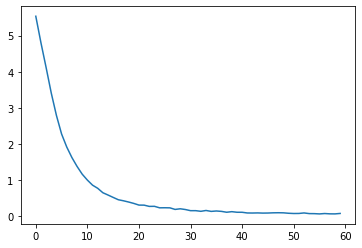

In [85]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.show()

# Evaluation

In [86]:
# https://bg.wikinews.org/wiki/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BD%D1%81%D0%B8%D1%80%D0%B0%D0%BD%D0%B5%D1%82%D0%BE_%D0%BD%D0%B0_%D0%A2%D0%B5%D0%B2%D0%B0%D1%82%D1%80%D0%BE%D0%BD_%D1%89%D0%B5_%D0%B1%D1%8A%D0%B4%D0%B5_%D0%BF%D1%80%D0%B5%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%B5%D0%BD%D0%BE
text = """
Дни, използвани от слънчевите календари.
При слънчевите календари датата отговаря 
на слънчевия ден. Денят може да се състои 
от периода между изгрев и залез слънце, 
последван от нощта, или може да представлява 
времето между повтарящи се събития, например 
два залеза. Дължината може да се променя малко 
през годината или може да се използва среден 
слънчев ден. Други типове календари също могат 
да използват слънчевия ден.

Юлиански и Григориански календар.
Юлианският календар е въведен от римския диктатор 
Юлий Цезар през 46 г. пр.н.е. При него месеците са 
по-дълги от лунния цикъл и затова той не е удобен за 
следене на лунните фази, за сметка на това много точно 
показва сезоните. Обикновените години имат 365 дена, 
а всяка четвърта година е високосна, което означава, 
че има 366 дни. Така продължителността на средната 
година е 365,25 дни.
"""

stop_words = {"и","на","в", ".", "се", "да", \
              "от", "или", "през", "а", "може",\
              "например", "той", "не", "при", "е",\
              "за", "че","има", "са"}

In [87]:
text = re.sub(r"[,\"]", r"", text.strip())
text = re.sub(r"\.", r" . ", text.strip())
tokens = text.split()
tokens[0:6]

['Дни', 'използвани', 'от', 'слънчевите', 'календари', '.']

In [88]:
model.eval()

MAX_SPAN_MENTION = 2
with torch.no_grad():
    for i in range(len(tokens)):
        if tokens[i].lower() in stop_words :
            continue;
        for span in range(MAX_SPAN_MENTION): 
            left_tok_start = max(i+span-5,0)
            right_tok_end = min(i+span+5,len(tokens))
            # On stop word continue
            if tokens[min(i+span,len(tokens)-1)].lower() in stop_words:
                continue;
            #print(" ".join(tokens[left_tok_start: right_tok_end]))
            vec = hugface_mdl.encode(" ".join(tokens[left_tok_start: right_tok_end]))
            predicted = model(torch.from_numpy(vec).reshape(-1))
            probabilities = F.softmax(predicted.view(-1),dim=0)
            max_prob = torch.max(probabilities)
            argmax_prob = torch.argmax(probabilities)
            entity_idx = class_to_entity_idx[argmax_prob.item()]
            tokens_joined = ' '.join(tokens[i:i+span+1])
            if entity_idx != -1 and max_prob > 0.95:
                print(f"{tokens_joined}=={max_prob}=>{entities_df.iloc[entity_idx]['title']}")
                #break
        
    

Дни==0.999186098575592=>Европа
Дни използвани==0.9998431205749512=>Европа
използвани==0.9998431205749512=>Европа
слънчевите==0.9983568787574768=>Европа
слънчевите календари==0.9634156227111816=>Европа
календари==0.9634156227111816=>Европа
слънчевите календари==0.9982030391693115=>България
календари==0.9982030391693115=>България
календари датата==0.9999433755874634=>България
датата==0.9999433755874634=>България
датата отговаря==0.9992617964744568=>България
отговаря==0.9992617964744568=>България
слънчевия==0.9958718419075012=>България
залез==0.9956173896789551=>Варна
залез слънце==0.9972787499427795=>Варна
слънце==0.9972787499427795=>Варна
слънце последван==0.9942071437835693=>Варна
последван==0.9942071437835693=>Варна
събития==0.9684929847717285=>София
два залеза==0.9797189235687256=>София
залеза==0.9797189235687256=>София
използва==0.9788632988929749=>Европа
римския диктатор==0.9706332087516785=>България
диктатор==0.9706332087516785=>България
него==0.9741998314857483=>Рим
много точно==